In [1]:
import Pkg; Pkg.activate(joinpath(@__DIR__,"..")); Pkg.instantiate();
using LinearAlgebra
using ForwardDiff
using PyPlot

 Activating environment at `D:\TANG Yunxi\CodingPrac\CMU_HW1\Project.toml`


# Question 1: Implicit Integrators (25 pts)
In this question we'll be taking a deeper look into implicit integration techniques, and some of the advantages they bring.

## Part (a): Implicit Midpoint (3 pts)
Implement implicit midpoint integration for the simple pendulum with $m = l = 1$ and $g = 9.81$:
$$ x_{n+1} = x_n + h f\left(\frac{x_{n+1} + x_n}{2}\right) $$

In [2]:
# TASK: Implement the `implicit_midpoint_pendulum!` function
"""
    x2 = implicit_midpoint_pendulum!(x2, x1, h; [m,l,g])

Evaluate the discrete pendulum dynamics with mass `m`, length `l`, and gravity `g` using
implicit midpoint:

``x_{n+1} = x_n + h f\\left(\\frac{x_{n+1} + x_n}{2}\\right)``
"""
function pendulum_dynamics(x, params)
    # Dynamics Equation for Pendulumn
    g = params.g
    l = params.l
    q = x[1]
    qd = x[2]
    qdd = -(g/l)*sin(q)
    return [qd;qdd]
end

function implicit_midpoint_pendulum(x2, x1, h, params)
    #  Implicit Midpoint
    return x1 + h * pendulum_dynamics((x1 + x2) / 2, params)
end

implicit_midpoint_pendulum (generic function with 1 method)

In [3]:
# robot model
struct params
    l
    g 
    m 
end
param = params(1.0, 9.81, 1.0)
xd = pendulum_dynamics([0.5;0.0], param)
x1 = [0.0; 0.5] 
x2 = [0.1; 0.6]
h = 0.1
x2_new = implicit_midpoint_pendulum(x2, x1, h, param)

2-element Array{Float64,1}:
 0.05500000000000001
 0.45097043494546457

## Part (b): Solve using Newton's Method (10 pts)
Use Newton's method to solve for $x_{n+1}$ with initial guess $x_{n+1} = x_n$. Solve such that the 2-norm of the residual is less than 1e-6. 

**NOTE**: It should take 5 iterations or less. If it's taking more iterations than that, you're doing something wrong.

In [30]:
# TASK: Complete the following function
"""
    implicit_midpoint_solve!(x2,x1,h)

Find the `x2` that satisfies implicit midpoint integration for the pendulum dynamics. 

Should modify `x2` in-place and return a vector of 2-norm residuals. The input value of `x2`
should be used as the initial guess.
"""
function implicit_midpoint_solve!(x2, x1, h, params; ϵ=1e-6)::Vector{Float64}
    # Newton's method
    x_n = [x2[1]; x2[2]]
    residuals = Float64[]
    res_norm = norm(x_n - implicit_midpoint_pendulum(x_n, x1, h, params))
    residuals = [res_norm]
    while residuals[end] > ϵ
        res = x_n - implicit_midpoint_pendulum(x_n,x1,h,params)
        ∇res = ForwardDiff.jacobian(x->x-implicit_midpoint_pendulum(x,x1,h,params),x_n)
        Δx = -∇res\res
        x_n = x_n + Δx
        residuals = [residuals norm(res)]
    end
    x2[1] = x_n[1]
    x2[2] = x_n[2]
    return vec(residuals)
end

implicit_midpoint_solve!

2-element Array{Float64,1}:
 1.0579750727230097
 0.1595014544601945

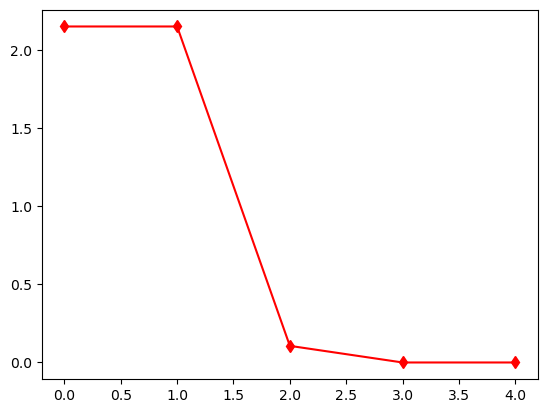

In [35]:
x1 = [1; 1.] 
x2 = [2; 2.] 
h = 0.1
trail_res = implicit_midpoint_solve!(x2, x1, h, param)
plot(trail_res,"rd-")
display(x2)

## Part (c): Energy Analysis (2 pts)
Simulate with $h=0.1$ for 1 hour and plot the total energy of the system vs time:
$$ E = \frac{1}{2} m l^2 \omega^2 + m g l (1 - \cos \theta) $$

Start the simulation with an initial state of 45 degrees and zero velocity.

In [64]:
# TASK: Compute the energy of the system. Store the result in the vector `energy_implicit::Vector{Float64}`
function compute_energy(x, params)::Float64
    θ = x[1]
    ω = x[2]
    m = params.m
    l = params.l
    g = params.g
    return 0.5*m*l*l*ω*ω + m*g*l*(1-cos(θ))
end

function forward_simulation_implicit(func, x0, h, tf, params)
    # run a forward simulation
    t_hist = Array(range(0,tf,step=h))
    x_hist = zeros(length(x0), length(t_hist))
    E_hist = zeros(length(t_hist))
    x = x0
    x_hist[:,1]=x
    E_hist[1] = compute_energy(x, param)
    for i=1:length(t_hist)-1
        func(x, x0, h, params)
        x_hist[:,i+1] = x
        E_hist[i+1] = compute_energy(x, param)  
    end
    return t_hist, x_hist, E_hist
end
x0 = [deg2rad(45);0.0]
h = 0.1
tf = 3600
t_hist, x_hist, E_hist = forward_simulation_implicit(implicit_midpoint_solve!, x0, h, tf, param)


([0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9  …  3599.1, 3599.2, 3599.3, 3599.4, 3599.5, 3599.6, 3599.7, 3599.8, 3599.9, 3600.0], [0.7853981633974483 0.7513107220091747 … 0.4690136486537746 0.2609668516955864; 0.0 -0.6817488277654714 … -1.9053888078993637 -2.255547131264399], [2.8732824765599685, 2.8732937275324617, 2.8735560823618016, 2.874429956708484, 2.8757415566304667, 2.876612660989817, 2.876296943048544, 2.875075575542977, 2.873908574550533, 2.8733664341367273  …  2.876558390897007, 2.87557185165095, 2.8742782536322027, 2.8734919780490276, 2.873286832798331, 2.8732822787179555, 2.873304669594133, 2.8736315491649345, 2.8745904267069875, 2.8759035374028428])

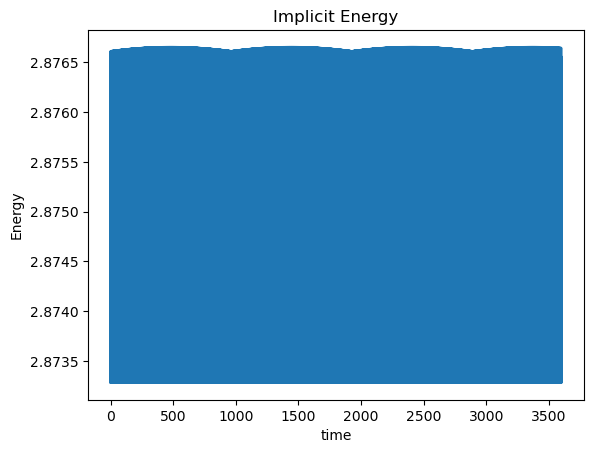

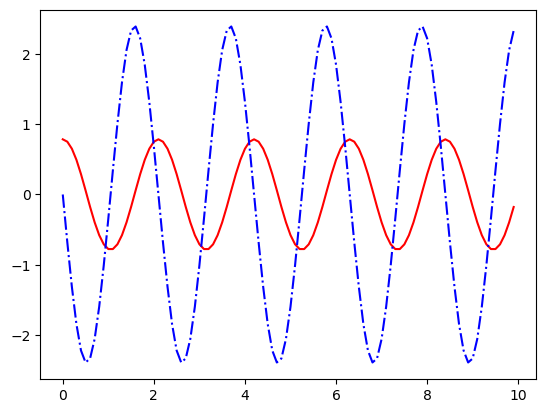

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x0000000002561520>

In [65]:
figure(1)
plot(t_hist, E_hist)
xlabel("time")
ylabel("Energy")
title("Implicit Energy")

figure(2)
plot(t_hist[1:100],x_hist[1,1:100],"r")
plot(t_hist[1:100],x_hist[2,1:100],"b-.")

## Part (d): RK4 Comparison (5 pts)
Compare the energy behavior of the implicit midpoint integrator with a 4th order Runge Kutta integrator.

In [70]:
# TASK: implement a 4th order Runge Kutta integrator for the pendulum (3 pts)
"""
    rk4(x, h)

Integrate the pendulum dynamics with a 4th Order Runge Kutta method at states `x` and time step `h`.
"""
function rk4(x, h, params)
    # implement rk4
    k1 = pendulum_dynamics(x, params)
    k2 = pendulum_dynamics(x + 0.5 * h * k1, params)
    k3 = pendulum_dynamics(x + 0.5 * h * k2, params)
    k4 = pendulum_dynamics(x +       h * k3, params)
    xnext = x + (h/6)*(k1+2*k2+2*k3+k4)
    return xnext
end

function forward_simulation_rk(x0, h, tf, params)
    # run a forward simulation
    t_hist = Array(range(0,tf,step=h))
    x_hist = zeros(length(x0), length(t_hist))
    E_hist = zeros(length(t_hist))
    x = x0
    x_hist[:,1]=x
    E_hist[1] = compute_energy(x, params)
    for i=1:length(t_hist)-1
        x = rk4(x, h, params)
        x_hist[:,i+1] = x
        E_hist[i+1] = compute_energy(x, params) 
    end
    return t_hist, x_hist, E_hist
end

forward_simulation_rk (generic function with 1 method)

In [71]:
# TASK: Compute the energy behavior of rk4. Store the result in `energy_rk4::Vector{Float64}` (1 pt)
# TASK: Generate a plot of energy vs time comparing implicit midpoint with rk4 (1 pt)
x0 = [deg2rad(45);0.0]
h = 0.1
tf = 3600
t_hist_rk, x_hist_rk, E_hist_rk = forward_simulation_rk(x0, h, tf, param)

([0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9  …  3599.1, 3599.2, 3599.3, 3599.4, 3599.5, 3599.6, 3599.7, 3599.8, 3599.9, 3600.0], [0.7853981633974483 0.7509167960069619 … -0.6409269921650764 -0.6007286617990941; 0.0 -0.6855487833966804 … 0.11210678320029632 0.6864979501162408], [2.8732824765599685, 2.873254280681685, 2.873212007997525, 2.8731815403703846, 2.8731734236908553, 2.8731585475208, 2.873104551606817, 2.873031340179535, 2.87298529871322, 2.872976501040057  …  1.9533240501760947, 1.9533085931760228, 1.9532976953998331, 1.9532732503054462, 1.953232514927166, 1.953195161683567, 1.953176469704731, 1.9531698250567824, 1.9531587323878434, 1.9531356462162517])

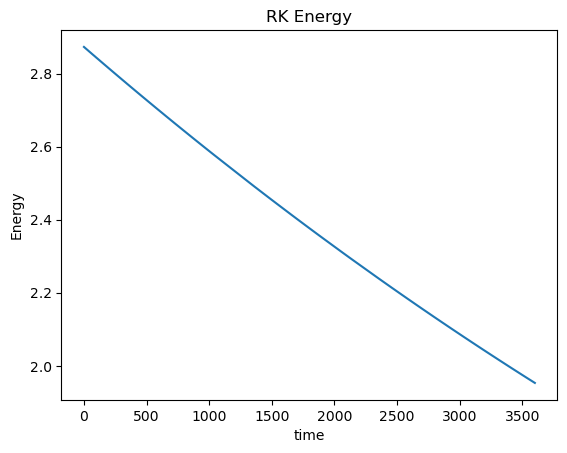

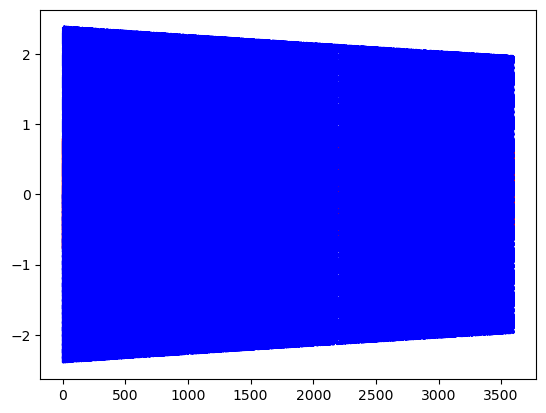

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x0000000061D05CA0>

In [77]:
figure(3)
plot(t_hist_rk, E_hist_rk)
xlabel("time")
ylabel("Energy")
title("RK Energy")

figure(4)
plot(t_hist_rk,x_hist_rk[1,:],"r")
plot(t_hist_rk,x_hist_rk[2,:],"b-.")

## Part (e): Evaluating the Jacobian (5 pts)
Computing the Jacobian for an explicit integrator like RK4 is straightforward, since it's just a basic application of the chain rule (you should do this for practice, and can check your result with ForwardDiff). 

Computing the Jacobian for an implicit integrator is not as trivial since we use Newton's method to compute the next step. However, we can use the [implicit function theorem](https://en.wikipedia.org/wiki/Implicit_function_theorem), which can be easily derived by taking a 1st order Taylor series expansion of $f(x,y) = 0$:
$$ f(x,y) = 0 \implies f(x + \Delta x, y + \Delta y) \approx f(x,y) + \frac{\partial f}{\partial x} \Delta x + \frac{\partial f}{\partial y} \Delta y = 0 $$
Dropping $f(x,y)$ (since it's zero) and solving for $\Delta x$ we obtain an expression for our Jacobian:
$$ \Delta x = -\frac{\partial f}{\partial x}^{-1} \frac{\partial f}{\partial y} \Delta y $$

Use this to compute the Jacobian of the implicit integrator, evaluated at $\theta = \omega = 0$. 

In [91]:
# TASK: Compute the Jacobian of the implicit midpoint integrator for h = 0.1. (3 pts)
#       Store the result in `Amid::Matrix{Float64}` of size (2,2)
Amid = zeros(2,2)
x0 = [0.0;0.0]
h = 0.1
dfdx = ForwardDiff.jacobian(x->x-implicit_midpoint_pendulum(x,x0,h,param),x0)
dfdy = ForwardDiff.jacobian(x->x-implicit_midpoint_pendulum(x0,x,h,param),x0)
Amid = ([1 0; 0 1]-dfdy)\dfdx
egs = eigvals(Amid)
norm.(egs)

2-element Array{Float64,1}:
 1.0
 1.0

In [92]:
# TASK: Compute the magnitude of the eigenvalues of A for 0 ≤ h ≤ 1.  (1 pt)
#       Store the result in `eigs_implicit::Matrix{Float64}` of size (101,2)
function compute_J(x, h, params)
    Amid = zeros(2,2)
    x0 = x
    dfdx = ForwardDiff.jacobian(x->x-implicit_midpoint_pendulum(x,x0,h,param),x0)
    dfdy = ForwardDiff.jacobian(x->x-implicit_midpoint_pendulum(x0,x,h,param),x0)
    Amid = ([1 0; 0 1]-dfdy)\dfdx
    eig_norm = norm.(eigvals(Amid))
    return Amid, eig_norm
end

function compute_J_rk(x, h, params)
    Amid = zeros(2,2)
    x0 = x
    ∂f∂x = ForwardDiff.jacobian(x->rk4(x,h,params),x0)
    Amid = [1 0; 0 1] + h * ∂f∂x
    eig_norm = norm.(eigvals(Amid))
    return Amid, eig_norm
end

compute_J_rk (generic function with 1 method)

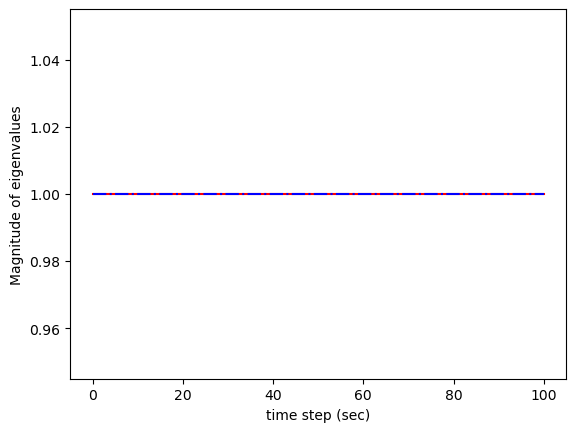

PyObject Text(24.00000000000002, 0.5, 'Magnitude of eigenvalues')

In [93]:
hs = range(0,100, length=101)
eigs_implicit = zeros(101,2)
x0 = [0.0;0.0]
for k=1:length(hs)
    h = hs[k]
    Amid, eig_norm = compute_J(x0, h, param)
    eigs_implicit[k,:] = eig_norm
end
    
# TASK: Plot the eigenvalues vs time step (1 pt)
plot(hs, eigs_implicit[:,1],"r")
plot(hs, eigs_implicit[:,2],"b-.")
xlabel("time step (sec)")
ylabel("Magnitude of eigenvalues")

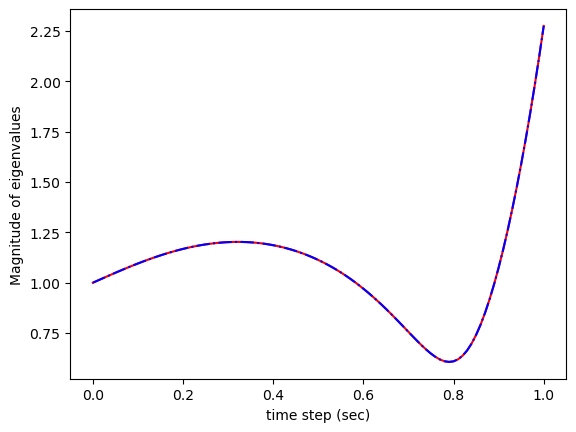

PyObject Text(24.00000000000002, 0.5, 'Magnitude of eigenvalues')

In [95]:
hs = range(0, 1, length=101)
eigs_implicit = zeros(101,2)
x0 = [0.0;0.0]
for k=1:length(hs)
    h = hs[k]
    Amid, eig_norm = compute_J_rk(x0, h, param)
    eigs_implicit[k,:] = eig_norm
end
    
# TASK: Plot the eigenvalues vs time step (1 pt)
plot(hs, eigs_implicit[:,1],"r")
plot(hs, eigs_implicit[:,2],"b-.")
xlabel("time step (sec)")
ylabel("Magnitude of eigenvalues")

### NOTE:
Obviously something special is going on here. Implicit midpoint is a "symplectic" integrator. That means it conserves energy (up to numerical roundoff/truncation error). Implicit midpoint is also the simplest "collocation" method. More about those later...